In [1]:
import pandas as pd
import numpy as np
import statistics 

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

###
from pmdarima.arima import auto_arima
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

plt.style.use('ggplot')
%matplotlib inline

In [2]:
#Hiding warnings (boring messages :@)
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

pd.options.mode.chained_assignment = None 

# Case 1

Basically: Analyze the data and predict 10 years

In [3]:
df1 = pd.read_csv('TFP.csv')
df1.year = pd.to_datetime(df1.year,format = '%Y', errors='raise')

In [4]:
country_grouped = df1.groupby('isocode')
df1.head()

,isocode,year,rtfpna
0,USA,1950-01-01,0.617148
1,USA,1951-01-01,0.629588
2,USA,1952-01-01,0.638451
3,USA,1953-01-01,0.651858
4,USA,1954-01-01,0.646179


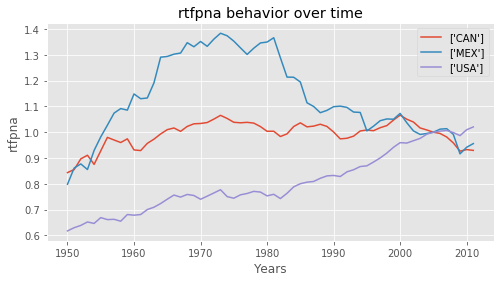

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
country_grouped.apply(lambda x: ax.plot(x.year,x.rtfpna, label = x['isocode'].unique()))
plt.title('rtfpna behavior over time')
plt.xlabel('Years')
plt.ylabel('rtfpna')
ax.legend()

TFP = Total factor productivity

It is possible to see that the USA maintained steady growth throughout the historical series, while Mexico saw a fall that almost equaled the level of 1950.

Canada advanced laterally over the years with a steady result between 0.9 and 1.

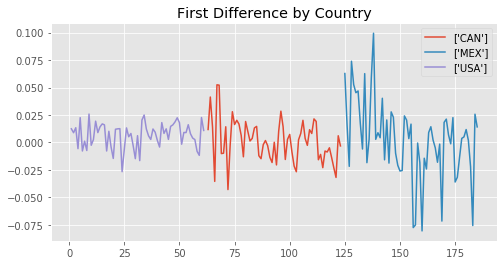

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))
country_grouped.apply(lambda x: ax.plot(x.rtfpna.diff().dropna(),label=x.isocode.unique()))
plt.title("First Difference by Country")
ax.legend()

It shows that each country has the data distributed in a different way, the MEX with greater noise (due to its series containing ups and downs), the USA grows constantly (so the data is better behaved) CAN has already presented an average value with some noise.

Text(0.5, 1.0, 'histogram')

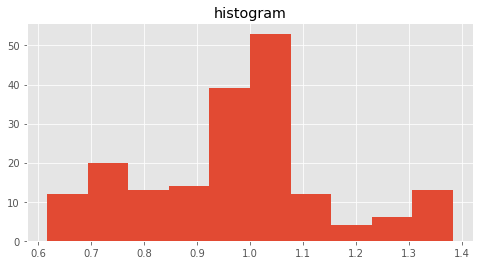

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
df1.rtfpna.hist()
plt.title("histogram")

The histogram shows that most values are close to 1 (similar to a normal distribution)

In [8]:
def predict_country_values(df):
    
    #country = df1.isocode.unique()[count]
    country = df['isocode'].unique()
    df.drop(['isocode'],axis=1,inplace=True)
    df.apply(lambda x: x.year.year, axis=1)
    df.set_index('year',inplace=True)
    df.index = df.index.year
    
    model = auto_arima(df, start_p =1, start_q=1, max_p=6, max_q=6, m=12, start_P=0, seasonal=True, d=1, D=1, error_action='ignore', suppress_warnigs=True, stepwise=True, n_jobs=-1)
    
    model.fit(df) #Fit the model
    prevision = model.predict(n_periods=11) #Forecasting data
    prevision = pd.DataFrame(prevision, index=prev, columns=['rtfpna']) #Creating a data frame with forecast data
    
    fig, ax = plt.subplots(figsize=(8, 4))
    pd.concat([df,prevision],axis=1).plot(ax=ax)
    ax.legend(["original", "predict"]);
    plt.xlabel("years")
    plt.ylabel("rtfpna")
    plt.title("Preditc " + country)
    print("Akaike Information Criterion of model: "+ str(country) + " " + str("{:.2f}".format(model.aic())))


Akaike Information Criterion of model: ['USA'] -273.00
Akaike Information Criterion of model: ['CAN'] -228.61
Akaike Information Criterion of model: ['MEX'] -174.45


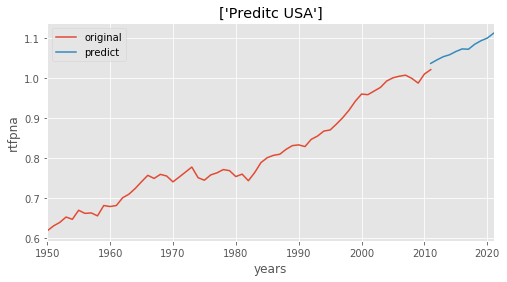

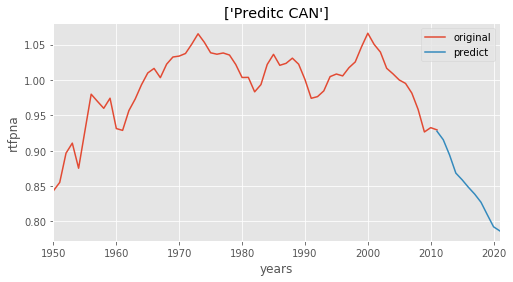

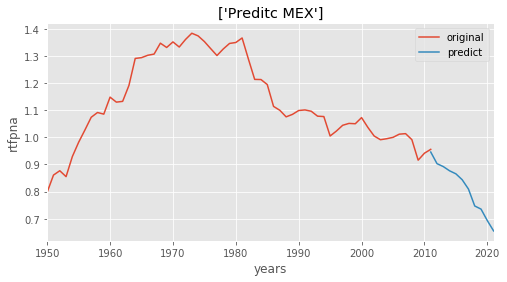

In [9]:
prev = np.arange(2011,2022,1) #Range to predict

for i in range(len(df1.isocode.unique())):
    df_actual = df1[df1['isocode'] == df1['isocode'].unique()[i]]
    predict_country_values(df_actual)

The prediction was made using the ARIMA model, where it was used to present the data projection until 2022.

The Akaike Information Criterion metric that defines the quality of a model presented different values for each country.

Where USA obtained the lowest value, due to its data not being close to an average (not stationary).

# Case 2

# Pre processing data

In [10]:
df = pd.read_csv('data_comexstat.csv', sep=',', encoding = "ISO-8859-1")

In [11]:
MILLION = 1000000

In [12]:
df.date = pd.to_datetime(df.date,yearfirst = True, errors='raise')
date_grouped = df.set_index('date')

# 1 - Evoluation of exports

In [13]:
#Validation product types and exportacion or importation
item_1 = (((date_grouped['product'] == 'soybeans') | (date_grouped['product'] == 'soybean_oil') | (date_grouped['product'] == 'soybean_meal')) & (date_grouped['type'] == 'Export'))
sampled_item_1 = date_grouped.apply(lambda x: x[item_1])

In [14]:
sampled_item_1.head()

,product,state,country,type,route,tons,usd
date,,,,,,,
1997-01-01,soybean_meal,GO,Netherlands,Export,Sea,419.070,119318.0
1997-01-01,soybean_meal,GO,Netherlands,Export,Sea,5000.000,1414250.0
1997-01-01,soybean_meal,MS,Germany,Export,Sea,140.672,38378.0
1997-01-01,soybean_meal,MS,Hungary,Export,Sea,15000.000,4042100.0
1997-01-01,soybean_meal,MS,Netherlands,Export,Sea,14000.000,3850162.0


In [15]:
#Sum of exportancion by month
exportacion = sampled_item_1['tons'].sum(level='date')/MILLION
months = sampled_item_1.index.unique()

Text(0, 0.5, 'Tonnes (millions)')

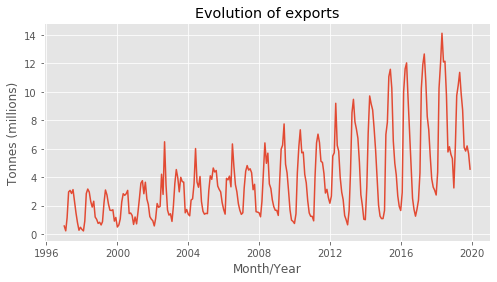

In [16]:
#Plot
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(months, exportacion)
plt.title('Evolution of exports')
plt.xlabel('Month/Year')
plt.ylabel('Tonnes (millions)')

Exports have increased over the years, and due to the distribution in the graph, it is possible to observe a seasonality in production (some months show a great drop in exports).

It is also possible to identify that this is a non-stationary distribution with an upward trend.

# 2 - Most importante products

Most exported product: Soybean.

Product with the highest return in dollars: Soybean.

Represented to be the most important product for Brazilian exports.

In [17]:
item_2 = ((date_grouped.index.year >= 2014) & (date_grouped['type'] == 'Export'))

In [18]:
sampled_item_2 = date_grouped.apply(lambda x: x[item_2])

In [19]:
#Sum values of each product in tonnes and dollars
total = sampled_item_2.set_index('product')
values_to_plot = total['tons'].sum(level='product')/1000
products_by_usd = total['usd'].sum(level='product')/MILLION

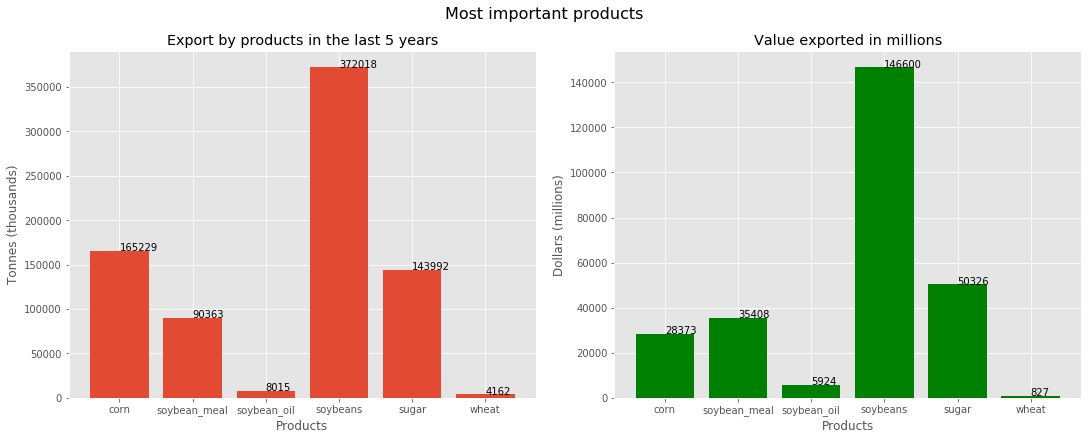

In [20]:
fig, axs = plt.subplots(1, 2, constrained_layout=True,figsize=(15,6))

products = sampled_item_2['product'].unique()

#Plot 1
axs[0].bar(products, values_to_plot)
axs[0].set_title('Export by products in the last 5 years')
axs[0].set_xlabel('Products')
axs[0].set_ylabel('Tonnes (thousands)')

for i in range(len(products)):
    axs[0].text(x = products[i],y = values_to_plot[i], s = int(values_to_plot[i]) )

products = sampled_item_2['product'].unique()

#Plot 2
axs[1].bar(products, products_by_usd, color = 'green')
axs[1].set_title('Value exported in millions')
axs[1].set_xlabel('Products')
axs[1].set_ylabel('Dollars (millions)')

for i in range(len(products)):
    axs[1].text(x = products[i],y = products_by_usd[i], s = int(products_by_usd[i]) )
    
    
fig.suptitle('Most important products', fontsize=16)

plt.show()

# 3 - Routes of corn exportation 

The most importante route is Sea representing 95.6% of total corn exports in last 5 years.

Sea exports represent the largest export channel for all types of products

In [21]:
#Get last 5 years, exports and corn
item_3 = ((date_grouped.index.year >= 2014) & (date_grouped['type'] == 'Export') & (date_grouped['product'] == 'corn'))
item_3_1 = ((date_grouped.index.year >= 2014) & (date_grouped['type'] == 'Export'))

In [22]:
#Extract data 
sampled_item_3 = date_grouped.apply(lambda x: x[item_3])
sampled_item_3_1 = date_grouped.apply(lambda x: x[item_3_1])

In [23]:
routes_corn_export = sampled_item_3.groupby('route').apply(lambda x: x.tons.sum()/1000)

In [24]:
#Sea representation export 
routes_corn_export['Sea']/routes_corn_export.sum()*100

95.6621529645743

In [25]:
#Function do calcule the tonnes exported by product
def route_importance(df_product):
    return df_product.groupby('route').apply(lambda x: x.tons.sum()/1000)

route_export = sampled_item_3_1.groupby('product').apply(route_importance)

In [26]:
#Show the values os each route of export by product
pd.DataFrame(route_export, columns=['tonnes'])

tonnes
product      route                
corn         Air         10.269443
             Ground      84.742677
             Other      268.070581
             River     6804.322840
             Sea     158062.153788
soybean_meal Air         22.025387
             Ground       8.625618
             Other       91.497169
             River        0.197400
             Sea      90241.465265
soybean_oil  Air          0.002977
             Ground     147.568310
             Other       30.132451
             River        4.172127
             Sea       7833.152083
soybeans     Air          0.060873
             Ground     102.726098
             Other     1519.020844
             River     9444.940451
             Sea     360951.896367
sugar        Air          0.033086
             Ground     742.326864
             Other       51.614345
             River       46.786306
             Sea     143151.635013
wheat        Air          0.001299
             Ground      39.585222
             Other        0.013718
             Sea       4123.251726

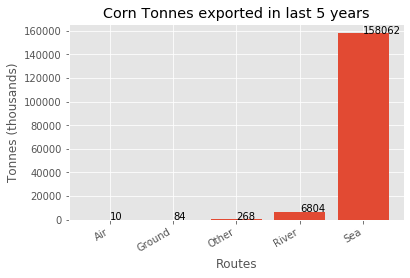

In [27]:
routes = sampled_item_3['route'].unique()
routes = np.sort(routes)

fig, ax = plt.subplots()
plt.bar(routes, routes_corn_export)
fig.autofmt_xdate()
plt.title('Corn Tonnes exported in last 5 years')
plt.xlabel('Routes')
plt.ylabel('Tonnes (thousands)')

for i in range(len(routes)):
    plt.text(x = routes[i], y = routes_corn_export[i], s = int(routes_corn_export[i]) )

# 4 - Most important partens with corn and sugar

173 countries are realized importation or exportation with Brazil considering sugar or corn after 2016 (3 yeas ago), was analised the top 10 countries using total of tonnes exported and total usd (dollars) movimented.

It was possible to identify that Iran was the principal destiny of exportation of theses products (23.3 millions of tonnes), and bigest font of usd (4.3 billions).
The second most import country was Egypt considering total of tonnes, but in relation with dollars payed to Brazil is the 4°.

Considering the importation the values are much smaller, the bigest value in tonnes is with Paraguay (4.3 millions of tonnes), and 602 millions of dollars.

In [28]:
#relationship_between_countries
rbc = pd.DataFrame()

In [29]:
item_4 = (((date_grouped['product'] == 'corn') | (date_grouped['product'] == 'sugar')) & (date_grouped.index.year >= 2016))
sampled_item_4 = date_grouped.apply(lambda x: x[item_4])

In [30]:
#Function to calcule the total of tonnes imported and exported per each country
def total_negotiation_export(df_country):
    export_total = df_country[df_country['type'] == 'Export']['tons'].sum()/MILLION
    return export_total

def total_negotiation_import(df_country):
    import_total = df_country[df_country['type'] == 'Import']['tons'].sum()/MILLION
    return import_total

In [31]:
#Function to calcule the total of USD (dollars) imported and exported per each country
def total_usd_export(df_country):
    export_total_usd = df_country[df_country['type'] == 'Export']['usd'].sum()/1000000000
    return export_total_usd

def total_usd_import(df_country):
    import_total_usd = df_country[df_country['type'] == 'Import']['usd'].sum()/MILLION
    return import_total_usd

In [32]:
#Apply the functions to sum
rbc['export_total'] = sampled_item_4.groupby('country').apply(total_negotiation_export)
rbc['import_total'] = sampled_item_4.groupby('country').apply(total_negotiation_import)

rbc['export_total_usd'] = sampled_item_4.groupby('country').apply(total_usd_export)
rbc['import_total_usd'] = sampled_item_4.groupby('country').apply(total_usd_import)

In [33]:
#Get the top 5 countries in import and export by tonnes and usd
top_tons_export = rbc.sort_values('export_total',ascending=False).head(10)
top_tons_import = rbc.sort_values('import_total',ascending=False).head(10)

top_usd_export = rbc.sort_values('export_total_usd',ascending=False).head(10)
top_usd_import = rbc.sort_values('import_total_usd',ascending=False).head(10)

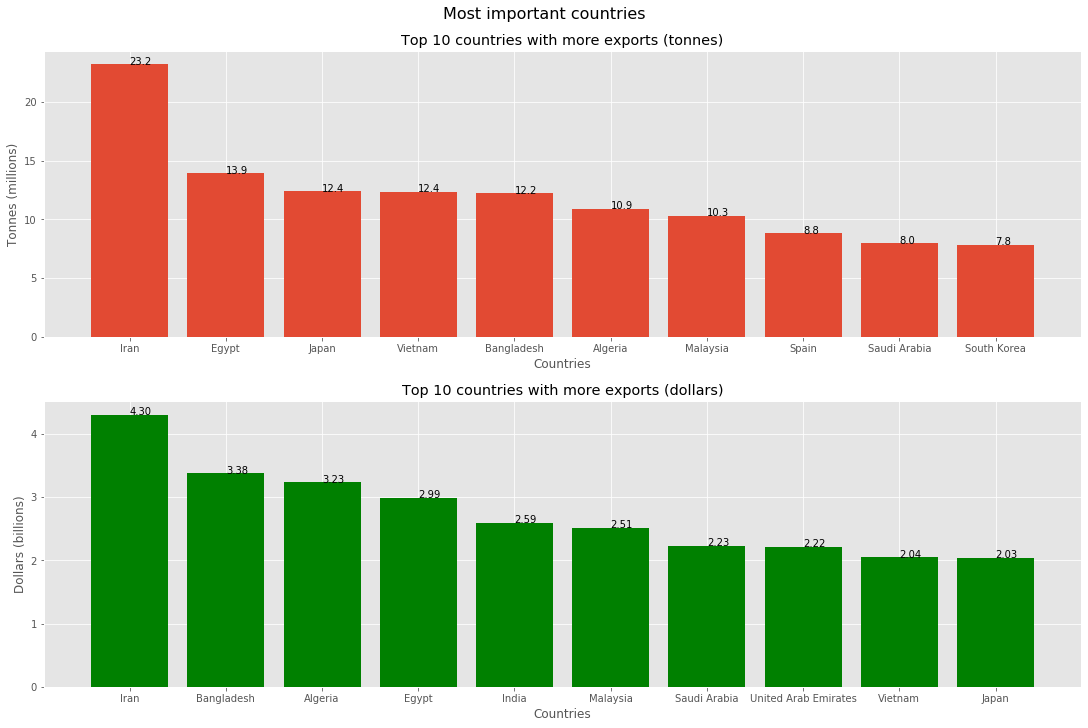

In [34]:
fig, axs = plt.subplots(2, 1, constrained_layout=True,figsize=(15,10))

#Plot 1
axs[0].bar(top_tons_export.index, top_tons_export['export_total'])
axs[0].set_title('Top 10 countries with more exports (tonnes)')
axs[0].set_xlabel('Countries')
axs[0].set_ylabel('Tonnes (millions)')

for i in range(len(top_tons_export)):
    axs[0].text(x = top_tons_export.index[i], y = top_tons_export['export_total'][i], s = "{:.1f}".format((top_tons_export['export_total'][i])))
    
#Plot 2
axs[1].bar(top_usd_export.index, top_usd_export['export_total_usd'], color = 'green')
axs[1].set_title('Top 10 countries with more exports (dollars)')
axs[1].set_xlabel('Countries')
axs[1].set_ylabel('Dollars (billions)')

for i in range(len(top_tons_export)):
    axs[1].text(x = top_usd_export.index[i], y = top_usd_export['export_total_usd'][i], s = "{:.2f}".format((top_usd_export['export_total_usd'][i])))
    
fig.suptitle('Most important countries', fontsize=16)

plt.show()

In [35]:
#Total imported (considering dollars)
top_usd_import

,export_total,import_total,export_total_usd,import_total_usd
country,,,,
Paraguay,0.107062,4.307481,0.150100,602.728932
Argentina,0.007612,2.137111,0.022978,396.012398
United States,1.688463,0.007377,0.808318,28.941893
Bolivia,0.032131,0.001667,0.019279,3.970951
Chile,0.437753,0.000940,0.142813,0.828143
Mexico,2.565935,0.000065,0.440084,0.781056
Italy,0.703510,0.000442,0.115976,0.533616
Netherlands,2.484760,0.000081,0.453534,0.308301
Germany,0.022942,0.000089,0.019266,0.295132


In [36]:
#Total imported (considering tonnes)
top_tons_import

,export_total,import_total,export_total_usd,import_total_usd
country,,,,
Paraguay,0.107062,4.307481,0.150100,602.728932
Argentina,0.007612,2.137111,0.022978,396.012398
United States,1.688463,0.007377,0.808318,28.941893
Bolivia,0.032131,0.001667,0.019279,3.970951
Chile,0.437753,0.000940,0.142813,0.828143
Italy,0.703510,0.000442,0.115976,0.533616
Guatemala,0.382155,0.000320,0.062576,0.112903
Germany,0.022942,0.000089,0.019266,0.295132
Netherlands,2.484760,0.000081,0.453534,0.308301


# 5 - most importante UF consediring exportation by product

In almost all of the top 5, with the first in two categories.
The state of PR is present in all the top 5, but its total production considering all UFs is still below MT.

In [37]:
item_5 = ((date_grouped['type'] == 'Export'))

In [38]:
sampled_item_5 = date_grouped.apply(lambda x: x[item_5])

In [39]:
#Get the first bigest values in tonnes per each state
def sum_by_UF(df_product):
    return df_product.groupby('state').apply(lambda x: x['tons'].sum()/1000000).sort_values(ascending=False).nlargest(5)

In [40]:
state_values = sampled_item_5.groupby('product').apply(lambda x: sum_by_UF(x))
index = state_values.index

In [41]:
#Most Importante States
mis = pd.DataFrame(state_values.values, columns=['tons'], index=index)

In [42]:
def states_metrics(actual_product):
    actual_product_values = mis[mis.index.get_level_values(0) == str(actual_product)]['tons'].values
    actual_product_states = mis[mis.index.get_level_values(0) == str(actual_product)].index.get_level_values(1)
    return actual_product_states, actual_product_values

In [43]:
plot_state=[]
for i in range(len(mis.index.get_level_values(0).unique())):
    plot_state.append(states_metrics(mis.index.get_level_values(0).unique()[i]))

Text(0.5, 0.98, 'Most important states by product export')

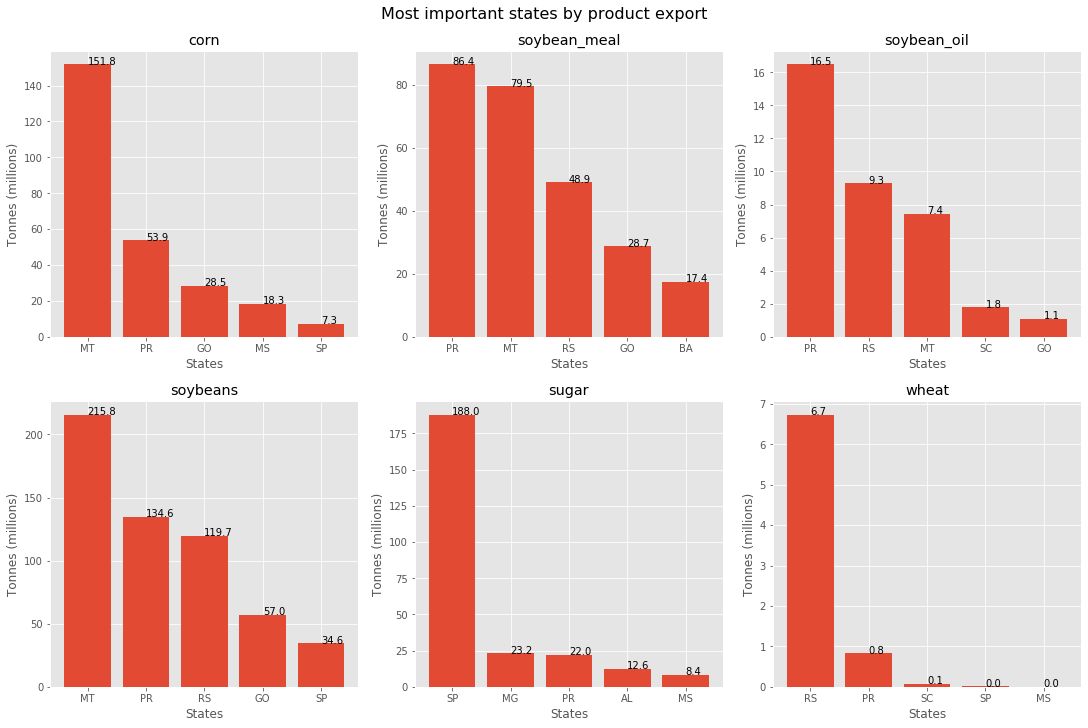

In [44]:
fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(15,10))
count = 0
for i in range(2):
    for j in range(3):
        axs[i,j].bar(plot_state[count][0], plot_state[count][1])
        axs[i,j].set_title(mis.index.get_level_values(0).unique()[count])
        axs[i,j].set_xlabel('States')
        axs[i,j].set_ylabel('Tonnes (millions)')

        for k in range(len(plot_state[count][0])):
            axs[i,j].text(x = plot_state[count][0][k], y = plot_state[count][1][k], s = "{:.1f}".format((plot_state[count][1][k])))
        count+=1
        
fig.suptitle('Most important states by product export', fontsize=16)

#  6 - Predict using ARIMA

Por enquanto só com soja

In [45]:
historical_serie = pd.read_excel('covariates.xlsx')

In [46]:
#historical_serie.head(5)
products_count = ['soybeans','soybean_meal','corn']

In [47]:
#Anual exportation
df_soybeans = ((date_grouped['type'] == 'Export') & (date_grouped['product'] == 'soybeans'))
df_soybean_meal = ((date_grouped['type'] == 'Export') & (date_grouped['product'] == 'soybean_meal'))
df_corn = ((date_grouped['type'] == 'Export') & (date_grouped['product'] == 'corn'))

In [48]:
def get_exportations(item_6):
    return date_grouped.apply(lambda x: x[item_6])

In [49]:
#Add values to list of forecast
products = []

products.append(df_soybeans)
products.append(df_soybean_meal)
products.append(df_corn)

In [50]:
def sjoin(x): return ';'.join(x[x.notnull()].astype(str))

In [51]:
def see_the_future(model,prev_range, modelo):
    modelo.fit(model) #Fit the model
    prevision = modelo.predict(n_periods=prev_range.size) #Forecasting data
    prevision = pd.DataFrame(prevision, index=prev_range, columns=['total_exported']) #Creating a data frame with forecast data

    fig, ax = plt.subplots(figsize=(8, 4))
    pd.concat([model,prevision],axis=1).plot(ax=ax)
    ax.legend(["original", "predict"]);
    plt.xlabel("years")
    plt.ylabel("rtfpna")
    print("Akaike Information Criterion of model: "+ str("{:.2f}".format(modelo.aic())))
    return pd.concat([model,prevision],axis=1).groupby(level=0, axis=1).apply(lambda x: x.apply(sjoin, axis=1))

In [52]:
#Use ARIMA to create the model's historical series
def use_ARIMA(model):
    model.set_index('year',inplace=True)
    prev_range = np.arange(2020,2031,1) #Range to predict
    modelo = auto_arima(model, start_p =1, start_q=1, max_p=6, max_q=6, m=12, start_P=0, seasonal=True, d=1, D=1, error_action='ignore', suppress_warnigs=True, stepwise=True, n_jobs=-1)
    predict_future = see_the_future(model, prev_range, modelo)
    return predict_future

In [53]:
#product = ((date_grouped['type'] == 'Export') & (date_grouped['product'] == products[i]))

Akaike Information Criterion of model: 67.11
Akaike Information Criterion of model: 42.20
Akaike Information Criterion of model: 63.21


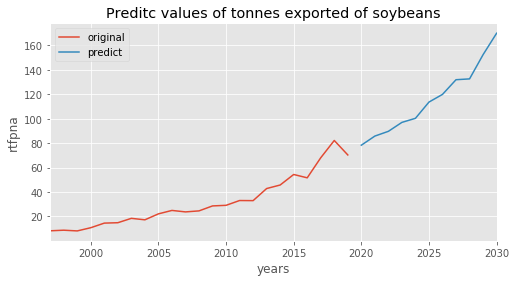

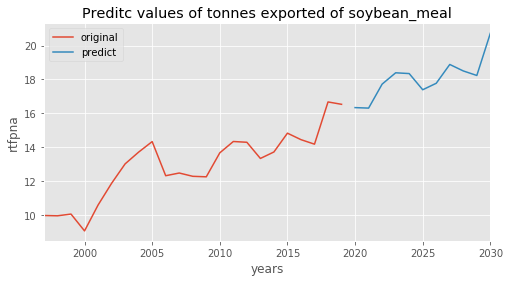

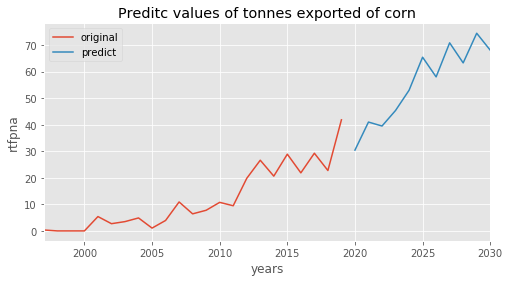

In [54]:
count = 0
predict_future2 = []
for i in products:
    exportations = get_exportations(i)
    total_exportation = exportations.groupby(exportations.index.year).apply(lambda x: x['tons'].sum()/MILLION)

    #Model for forecast 
    model = pd.DataFrame(total_exportation)
    model.reset_index(inplace=True)
    model.columns = ['year','total_exported']

    predict_future2.append(use_ARIMA(model))
    plt.title("Preditc values of tonnes exported of " + str(products_count[count]))
    count += 1

All products showed growth in the forecast.\
Soya beans in 2030 were twice the value of 2020, and corn had the same behavior.

# Linear regression to target values (missing values)

Prepare data to Xgboost\
The idea was to do the regression to identify the missing historical values, to be able to pass the complete dataframe for prediction using Xgboost.\
But it didn't work  :'(


In [55]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [56]:
#X = predict_future.drop(['total_exported'],axis=1)
#y = predict_future['total_exported']

In [57]:
#a = pd.concat([historical_serie,model],axis=1).fillna(method='ffill')
#a.head(-5)

In [58]:
#X = predict_future.sort_values('total_exported',ascending=False).index.values.reshape(-1,1)
#y = predict_future.sort_values('total_exported',ascending=False).values

In [59]:
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(X[X.columns])
#y_scaled = min_max_scaler.fit_transform(y.to_numpy().reshape(-1,1))

In [60]:
#reg = LinearRegression(normalize=True).fit(x_scaled, y_scaled)

In [61]:
#x_scaled_prev = min_max_scaler.fit_transform(prev_pass.reshape(-1,1))
#tager_pass_values = reg.predict(x_scaled_prev)
#tager_pass_values = min_max_scaler.inverse_transform(tager_pass_values)

In [62]:
#historical_serie['tagert'] = pd.concat([predict_future,pd.DataFrame(data=tager_pass_values, index=prev_pass, columns=['total_exported'])]).sort_index().values

# Regression to target

Using Xgboost to identify the main features that influence the model's value.\
With corn values

In [63]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [64]:
exportations = get_exportations(products[0])
total_exportation = exportations.groupby(exportations.index.year).apply(lambda x: x['tons'].sum()/MILLION)

#Model for forecast 
model = pd.DataFrame(total_exportation)
model.reset_index(inplace=True)
model.columns = ['year','total_exported']

predict_future =pd.concat([historical_serie,model],axis=1).fillna(method='ffill').dropna()

In [65]:
X = predict_future.drop(['total_exported'],axis=1)
X = X.iloc[:, :-1]
y = predict_future['total_exported']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [67]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

C:\Users\stiva\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\stiva\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [68]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)

In [69]:
xg_reg.fit(X_train,y_train)

[13:57:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, colsample_bytree=0.3, max_depth=5, n_estimators=10)

In [70]:
preds = xg_reg.predict(X_test)

In [71]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 23.300271


In [72]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[13:57:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [73]:
#Error values to each dataset (train vs test)
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,52.879242,2.021071,52.781620,4.292172
1,47.945334,1.804984,47.872511,3.907378
2,43.476656,1.613644,43.430570,3.616468
3,39.446409,1.437152,39.404710,3.302037
4,35.783653,1.287158,35.747416,3.072707


In [74]:
print((cv_results["test-rmse-mean"]).tail(1))

49    3.863302
Name: test-rmse-mean, dtype: float64


[13:57:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


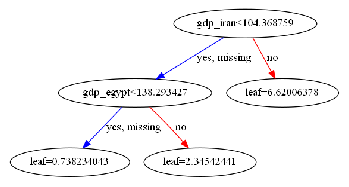

In [75]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [30, 20]
plt.show()

Each node in the tree represents how the algorithm performed the classification, and the leaf at each end represents the percentage of correctness of that path in the tree.

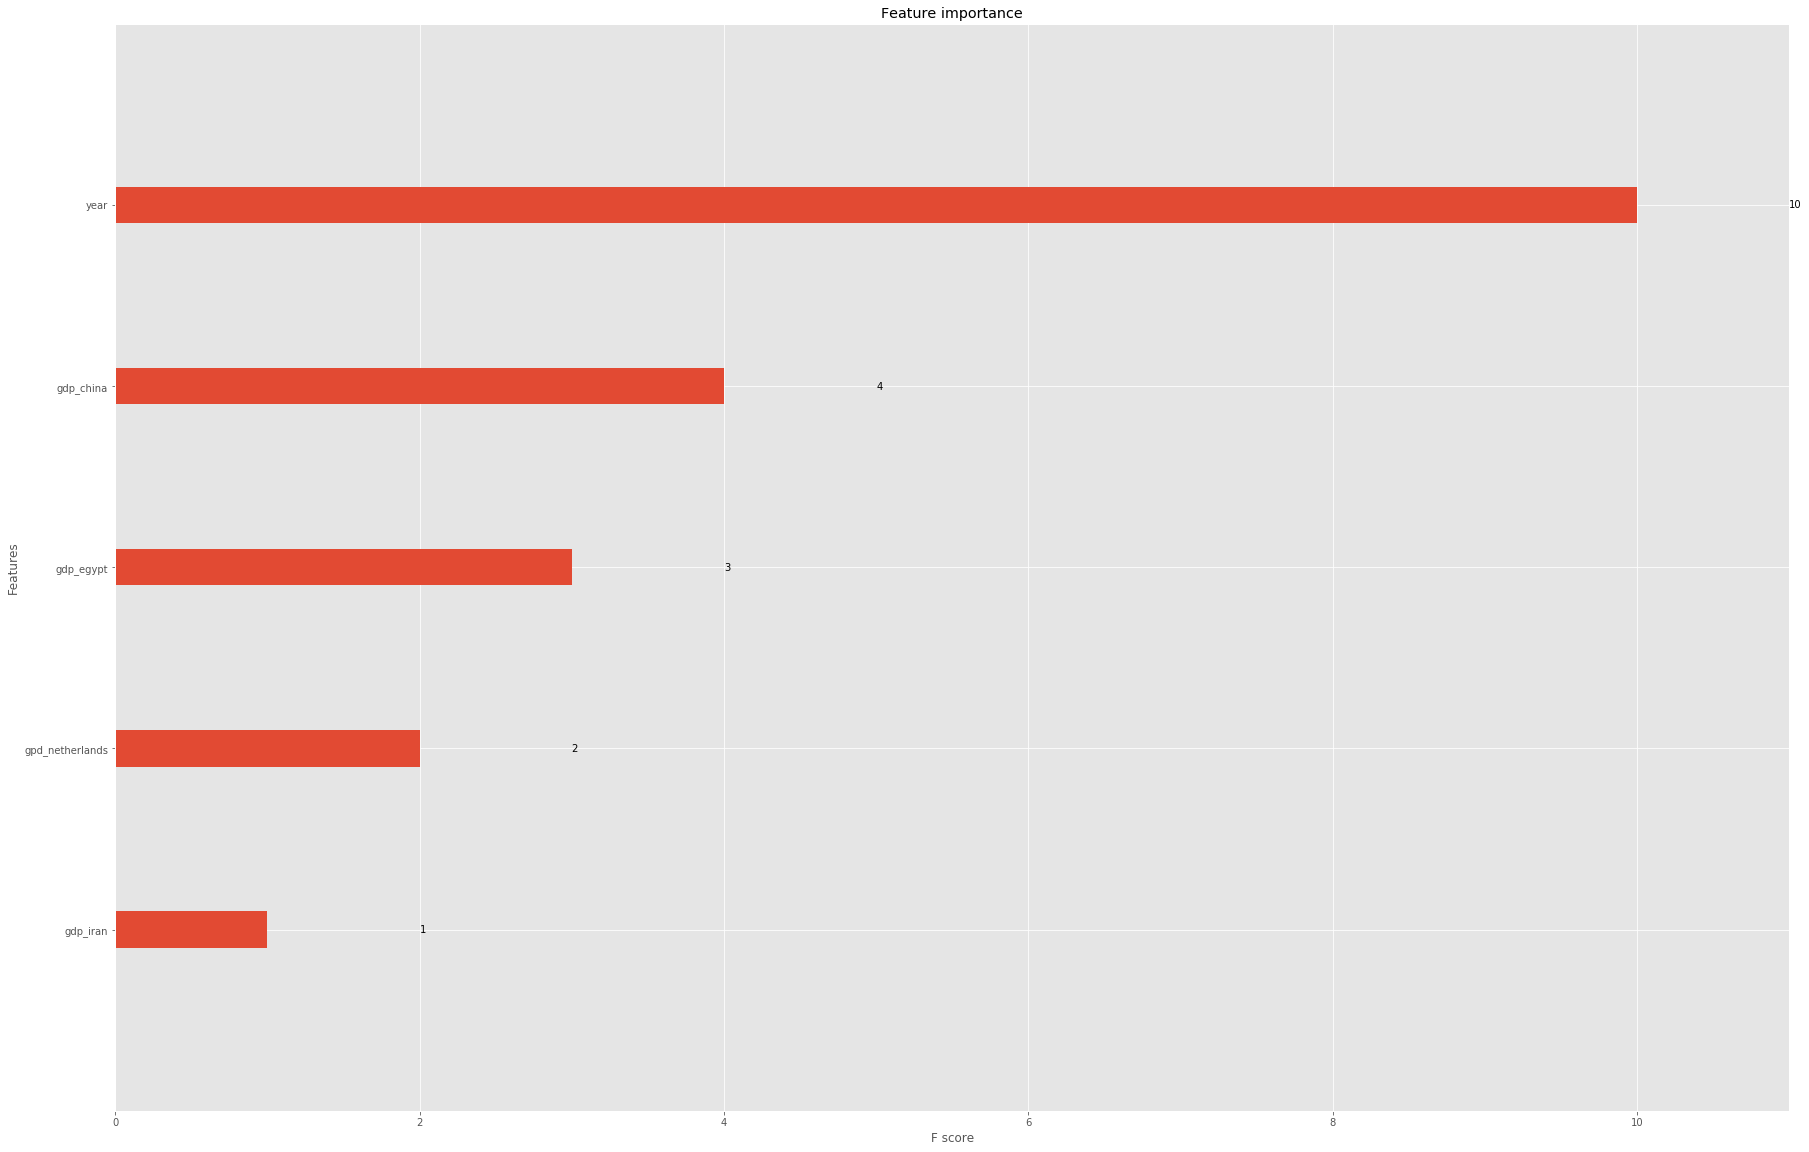

In [76]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [1, 10]
plt.show()

It shows the importance of each feature for the model, this chart shows the year as the biggest influence in determining the target.\
All additional data was used, and the model selected the gdp from China, Egypt as the most important.